### American Call Spread price

In [3]:
import math

class EuropeanPayoff():
    def __init__(self, expiry, payoffFun):
        self.expiry = expiry
        self.payoffFun = payoffFun
    def payoff(self, S):
        return self.payoffFun(S)
    def valueAtNode(self, t, S, continuation):
        return continuation

class AmericanPayoff():
    def __init__(self, expiry, payoffFun):
        self.expiry = expiry
        self.payoffFun = payoffFun
    def payoff(self, S):
        return self.payoffFun(S)
    def valueAtNode(self, t, S, continuation):
        return max(self.payoff(S), continuation)
    
def binomialPricer(S, r, vol, trade, n, calib):
    t = trade.expiry / n
    (u, d, p) = calib(r, vol, t)
    # set up the last time slice, there are n+1 nodes at the last time slice
    vs = [trade.payoff(S * u ** (n - i) * d ** i) for i in range(n + 1)]
    # iterate backward
    for i in range(n - 1, -1, -1):
        # calculate the value of each node at time slide i, there are i nodes
        for j in range(i + 1):
            nodeS = S * u ** (i - j) * d ** j
            continuation = math.exp(-r * t) * (vs[j] * p + vs[j + 1] * (1 - p))
            vs[j] = trade.valueAtNode(t * i, nodeS, continuation)
    return vs[0]

def crrCalib(r, vol, t):
    b = math.exp(vol * vol * t + r * t) + math.exp(-r * t)
    u = (b + math.sqrt(b * b - 4)) / 2
    p = (math.exp(r * t) - (1 / u)) / (u - 1 / u)
    return (u, 1/u, p)

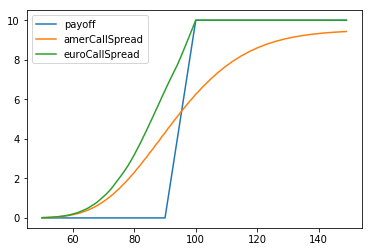

Euro callspread:  6.259190489575012
Amer callspread:  10.0


In [13]:
import matplotlib.pyplot as plt
def testAmerSpread():
    S0, r, vol = 100, 0.05, 0.2
    callSpread = lambda S: min(max(S - 90, 0), 10)
    euroPrice = lambda S: binomialPricer(S, r, vol, EuropeanPayoff(1, callSpread), 300, crrCalib)
    amerPrice = lambda S: binomialPricer(S, r, vol, AmericanPayoff(1, callSpread), 300, crrCalib)
    
    plt.plot(range(50, 150), [callSpread(i) for i in range(50, 150)], label='payoff')
    plt.plot(range(50, 150), [euroPrice(i) for i in range(50, 150)], label='euroCallSpread')
    plt.plot(range(50, 150), [amerPrice(i) for i in range(50, 150)], label='amerCallSpread')
    plt.legend()
    plt.show()
    print("Euro callspread: ", binomialPricer(S0, r, vol, EuropeanPayoff(1, callSpread), 300, crrCalib))
    print("Amer callspread: ", binomialPricer(S0, r, vol, AmericanPayoff(1, callSpread), 300, crrCalib))

testAmerSpread()

For American call spread, if r > 0, for all nodes with S > 100, the option holder should early exercise since it's already the maximum payoff.
Clearly the early exercise feature worths much more than an American call or put.

Note that American call spread is not equivelent to long American call with lower strike and short American call with higher strike. 
For the former, the holder of the call spread decides the time to exercise. For the latter the two American call option holders are the two counterparties. So they will exercise separately.
